# Recommender Systems 2017/18

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "movielens_10m.zip")
dataFile = zipfile.ZipFile("movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

URM_all

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

## And now load the content informations in the same way:
## In this case we are using tags

In [2]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

In [4]:
import numpy as np
ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)))
ICM_all = ICM_all.tocsr()

ICM_all

<65131x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

### Ouch, we need to add three empty items (why?):

In [5]:
missing_items = np.zeros((3, numTags))
missing_items = sps.csr_matrix(missing_items)
ICM_all = sps.vstack((ICM_all, missing_items))
ICM_all

<65134x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

In [6]:
features_per_item = (ICM_all > 0).sum(axis=1)
items_per_feature = (ICM_all > 0).sum(axis=0)

print(features_per_item.shape)
print(items_per_feature.shape)

(65134, 1)
(1, 16529)


In [7]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

(65134,)
(16529,)


In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

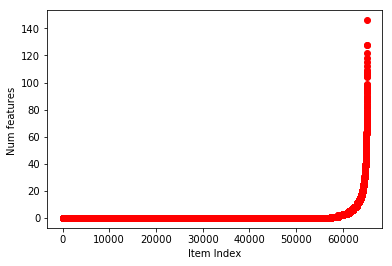

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

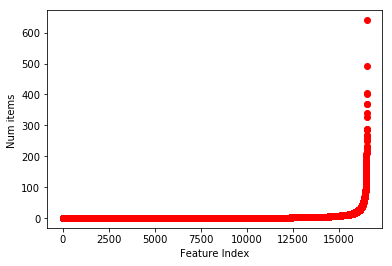

In [10]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [11]:
train_test_split = 0.80

numInteractions = URM_all.nnz


train_mask = np.random.choice([True,False], numInteractions, [train_test_split, 1-train_test_split])

userList = np.array(userList)
itemList = np.array(itemList)
ratingList = np.array(ratingList)


URM_train = sps.coo_matrix((ratingList[train_mask], (userList[train_mask], itemList[train_mask])))
URM_train = URM_train.tocsr()

test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((ratingList[test_mask], (userList[test_mask], itemList[test_mask])))
URM_test = URM_test.tocsr()

def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for i,user_id in  enumerate(userList_unique):
        
        if i % 500 == 0:
            print("User %d of %d" % (i, len(userList_unique)))

        relevant_items = URM_test[user_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP))

In [12]:
class BasicItemKNNRecommender(object):
    """ ItemKNN recommender with cosine similarity and no shrinkage"""

    def __init__(self, URM, k=50, shrinkage=100, similarity='cosine'):
        self.dataset = URM
        self.k = k
        self.shrinkage = shrinkage
        self.similarity_name = similarity
        if similarity == 'cosine':
            self.distance = Cosine(shrinkage=self.shrinkage)
        elif similarity == 'pearson':
            self.distance = Pearson(shrinkage=self.shrinkage)
        elif similarity == 'adj-cosine':
            self.distance = AdjustedCosine(shrinkage=self.shrinkage)
        else:
            raise NotImplementedError('Distance {} not implemented'.format(similarity))

    def __str__(self):
        return "ItemKNN(similarity={},k={},shrinkage={})".format(
            self.similarity_name, self.k, self.shrinkage)

    def fit(self, X):
        item_weights = self.distance.compute(X)
        
        item_weights = check_matrix(item_weights, 'csr') # nearly 10 times faster
        print("Converted to csr")
        
        # for each column, keep only the top-k scored items
        # THIS IS THE SLOW PART, FIND A BETTER SOLUTION        
        values, rows, cols = [], [], []
        nitems = self.dataset.shape[1]
        for i in range(nitems):
            if (i % 10000 == 0):
                print("Item %d of %d" % (i, nitems))
                
            this_item_weights = item_weights[i,:].toarray()[0]
            top_k_idx = np.argsort(this_item_weights) [-self.k:]
                        
            values.extend(this_item_weights[top_k_idx])
            rows.extend(np.arange(nitems)[top_k_idx])
            cols.extend(np.ones(self.k) * i)
        self.W_sparse = sps.csc_matrix((values, (rows, cols)), shape=(nitems, nitems), dtype=np.float32)

    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.dataset[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        # rank items
        ranking = scores.argsort()[::-1]
        if exclude_seen:
            ranking = self._filter_seen(user_id, ranking)
            
        return ranking[:at]
    
    def _filter_seen(self, user_id, ranking):
        user_profile = self.dataset[user_id]
        seen = user_profile.indices
        unseen_mask = np.in1d(ranking, seen, assume_unique=True, invert=True)
        return ranking[unseen_mask]

# We need to define Cosine similarity:

In [13]:
def check_matrix(X, format='csc', dtype=np.float32):
    if format == 'csc' and not isinstance(X, sps.csc_matrix):
        return X.tocsc().astype(dtype)
    elif format == 'csr' and not isinstance(X, sps.csr_matrix):
        return X.tocsr().astype(dtype)
    elif format == 'coo' and not isinstance(X, sps.coo_matrix):
        return X.tocoo().astype(dtype)
    elif format == 'dok' and not isinstance(X, sps.dok_matrix):
        return X.todok().astype(dtype)
    elif format == 'bsr' and not isinstance(X, sps.bsr_matrix):
        return X.tobsr().astype(dtype)
    elif format == 'dia' and not isinstance(X, sps.dia_matrix):
        return X.todia().astype(dtype)
    elif format == 'lil' and not isinstance(X, sps.lil_matrix):
        return X.tolil().astype(dtype)
    else:
        return X.astype(dtype)

In [14]:
import scipy
class ISimilarity(object):
    """Abstract interface for the similarity metrics"""

    def __init__(self, shrinkage=10):
        self.shrinkage = shrinkage

    def compute(self, X):
        pass


class Cosine(ISimilarity):
    def compute(self, X):
        # convert to csc matrix for faster column-wise operations
        X = check_matrix(X, 'csc', dtype=np.float32)

        # 1) normalize the columns in X
        # compute the column-wise norm
        # NOTE: this is slightly inefficient. We must copy X to compute the column norms.
        # A faster solution is to  normalize the matrix inplace with a Cython function.
        Xsq = X.copy()
        Xsq.data **= 2
        norm = np.sqrt(Xsq.sum(axis=0))
        norm = np.asarray(norm).ravel()
        norm += 1e-6
        # compute the number of non-zeros in each column
        # NOTE: this works only if X is instance of sparse.csc_matrix
        col_nnz = np.diff(X.indptr)
        # then normalize the values in each column
        X.data /= np.repeat(norm, col_nnz)
        print("Normalized")

        # 2) compute the cosine similarity using the dot-product
        dist = X * X.T
        print("Computed")
        
        # zero out diagonal values
        dist = dist - sps.dia_matrix((dist.diagonal()[scipy.newaxis, :], [0]), shape=dist.shape)
        print("Removed diagonal")
        
        # and apply the shrinkage
        if self.shrinkage > 0:
            dist = self.apply_shrinkage(X, dist)
            print("Applied shrinkage")    
        
        return dist

    def apply_shrinkage(self, X, dist):
        # create an "indicator" version of X (i.e. replace values in X with ones)
        X_ind = X.copy()
        X_ind.data = np.ones_like(X_ind.data)
        # compute the co-rated counts
        co_counts = X_ind * X_ind.T
        # remove the diagonal
        co_counts = co_counts - sps.dia_matrix((co_counts.diagonal()[scipy.newaxis, :], [0]), shape=co_counts.shape)
        # compute the shrinkage factor as co_counts_ij / (co_counts_ij + shrinkage)
        # then multiply dist with it
        co_counts_shrink = co_counts.copy()
        co_counts_shrink.data += self.shrinkage
        co_counts.data /= co_counts_shrink.data
        dist.data *= co_counts.data
        return dist


## Test it:

In [15]:
rec = BasicItemKNNRecommender(URM=URM_train, shrinkage=0.0, k=50)
rec.fit(ICM_all)

Normalized
Computed
Removed diagonal
Converted to csr
Item 0 of 65134
Item 10000 of 65134
Item 20000 of 65134
Item 30000 of 65134
Item 40000 of 65134
Item 50000 of 65134
Item 60000 of 65134


In [16]:
for user_id in userList_unique[0:10]:
    print(rec.recommend(user_id, at=5))

[ 5816  8368 40815  1196 33493]
[5952 1210 7153 3793  480]
[65133 21706 21719 21718 21717]
[4993 1210  589 6934 1200]
[5952  296 2571 7361  356]
[65133 21706 21719 21718 21717]
[65133 21706 21719 21718 21717]
[4993  296  260 7361 1198]
[ 260 8984  589  527 2571]
[65133 21706 21719 21718 21717]


In [17]:
evaluate_algorithm(URM_test, rec)

User 0 of 4009
User 500 of 4009
User 1000 of 4009
User 1500 of 4009
User 2000 of 4009
User 2500 of 4009
User 3000 of 4009
User 3500 of 4009
User 4000 of 4009
Recommender performance is: Precision = 0.6830, Recall = 0.0311, MAP = 0.6319


# Shrinkage

In [18]:
rec_s = BasicItemKNNRecommender(URM=URM_train, shrinkage=10.0, k=50)
rec_s.fit(ICM_all)
evaluate_algorithm(URM_test, rec_s)

Normalized
Computed
Removed diagonal
Applied shrinkage
Converted to csr
Item 0 of 65134
Item 10000 of 65134
Item 20000 of 65134
Item 30000 of 65134
Item 40000 of 65134
Item 50000 of 65134
Item 60000 of 65134
User 0 of 4009
User 500 of 4009
User 1000 of 4009
User 1500 of 4009
User 2000 of 4009
User 2500 of 4009
User 3000 of 4009
User 3500 of 4009
User 4000 of 4009
Recommender performance is: Precision = 0.6787, Recall = 0.0310, MAP = 0.6267


# IDF

In [19]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(65134, 16529)
(16529,)


In [20]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(check_matrix(ICM_idf, 'csc').indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(16529,)
(65134, 16529)
(16529,)


In [21]:
rec_idf = BasicItemKNNRecommender(URM=URM_train, shrinkage=0.0, k=50)
rec_idf.fit(ICM_idf)
evaluate_algorithm(URM_test, rec_idf)

Normalized
Computed
Removed diagonal
Converted to csr
Item 0 of 65134
Item 10000 of 65134
Item 20000 of 65134
Item 30000 of 65134
Item 40000 of 65134
Item 50000 of 65134
Item 60000 of 65134
User 0 of 4009
User 500 of 4009
User 1000 of 4009
User 1500 of 4009
User 2000 of 4009
User 2500 of 4009
User 3000 of 4009
User 3500 of 4009
User 4000 of 4009
Recommender performance is: Precision = 0.6765, Recall = 0.0307, MAP = 0.6250


# Unnormalized similarity matrix

In [22]:
rec_test = BasicItemKNNRecommender(URM=URM_train, shrinkage=0.0, k=50)
rec_test.W_sparse = ICM_all * ICM_all.T
evaluate_algorithm(URM_test, rec_test)

User 0 of 4009
User 500 of 4009
User 1000 of 4009
User 1500 of 4009
User 2000 of 4009
User 2500 of 4009
User 3000 of 4009
User 3500 of 4009
User 4000 of 4009
Recommender performance is: Precision = 0.6416, Recall = 0.0283, MAP = 0.5871
